In [ ]:
# imports 
import os 
os.environ['PYTHONHASHSEED'] = '42'
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import random 
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [34]:
#torch reproducibility 
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [39]:
class EnhancedStockDataFramework:
    def __init__(self, start_date="2015-01-01", end_date="2024-12-31"):
        self.start_date = start_date
        self.end_date = end_date
        self.raw_data = None
        self.processed_data = None
        self.failed_downloads = []
        self.successful_tickers = []
        
    def get_stock_universe(self):
        tickers = [
            # tech
            'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'ADBE', 'CRM',
            'ORCL', 'INTC', 'AMD', 'QCOM', 'AVGO', 'TXN', 'AMAT', 'LRCX', 'KLAC', 'MRVL',
            
            # finance
            'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'BK', 'USB', 'PNC', 'TFC',
            'COF', 'AXP', 'V', 'MA', 'PYPL', 'BRK-B', 'BLK', 'SPGI', 'ICE', 'CME',
            
            # health and pharma 
            'JNJ', 'PFE', 'UNH', 'ABT', 'TMO', 'DHR', 'BMY', 'MRK', 'ABBV', 'AMGN',
            'GILD', 'BIIB', 'REGN', 'VRTX', 'ILMN', 'ISRG', 'SYK', 'BSX', 'MDT', 'EW',
            
            # consumer discretionary 
            'AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'SBUX', 'TJX', 'LOW', 'BKNG', 'ABNB',
            'DIS', 'NFLX', 'CMCSA', 'VZ', 'T', 'CHTR', 'TMUS', 'ROKU', 'SPOT', 'UBER',
            
            # consumer staples
            'PG', 'KO', 'PEP', 'WMT', 'COST', 'CL', 'KMB', 'GIS', 'K', 'CPB',
            'TSN', 'HRL', 'SJM', 'CAG', 'MKC', 'CLX', 'CHD', 'EL', 'ULTA', 'TGT',
            
            # industrial and manufacturing
            'BA', 'CAT', 'DE', 'GE', 'HON', 'UPS', 'FDX', 'LMT', 'RTX', 'NOC',
            'MMM', 'EMR', 'ETN', 'ITW', 'PH', 'CMI', 'ROK', 'DOV', 'FTV', 'XYL',
            
            # energy and utilities
            'XOM', 'CVX', 'COP', 'EOG','VLO', 'MPC', 'PSX', 'KMI', 'OKE',
            'NEE', 'DUK', 'SO', 'AEP', 'EXC', 'XEL', 'PEG', 'ED', 'AWK', 'ATO',
            
            # materials and basic industries 
            'LIN', 'APD', 'ECL', 'SHW', 'FCX', 'NEM', 'FMC', 'LYB', 'DD', 'DOW',
            'PPG', 'NUE', 'STLD', 'MLM', 'VMC', 'PKG', 'IP','SON', 'AVY',
            
            # real estate and REITs
            'AMT', 'PLD', 'CCI', 'EQIX', 'SPG', 'O', 'WELL', 'AVB', 'EQR', 'DLR',
            'BXP', 'VTR', 'ARE', 'MAA', 'UDR', 'CPT', 'KIM', 'REG', 'FRT', 'BRX',
            
            # communication services
            'GOOGL', 'META', 'NFLX', 'DIS', 'CMCSA', 'VZ', 'T', 'CHTR', 'TMUS',
            'SNAP', 'PINS', 'MTCH', 'IAC', 'FOXA', 'WBD', 'LUMN', 'SIRI'
            
            # emerging growth and others
            'SHOP', 'ZM', 'DOCU', 'OKTA', 'SNOW', 'PLTR', 'RBLX', 'HOOD', 'COIN', 'RIVN'
        ]
        return list(set(tickers))
    
    def download_data(self, tickers, max_retries=3):
        print(f"Downloading data for {len(tickers)} stocks...")
        print(f"Date range: {self.start_date} to {self.end_date}")
        
        successful_data = {}
        failed_downloads = []
        
        batch_size = 10
        for i in range(0, len(tickers), batch_size):
            batch = tickers[i:i+batch_size]
            
            for ticker in batch:
                success = False
                for attempt in range(max_retries):
                    try:
                        stock = yf.Ticker(ticker)
                        hist = stock.history(start=self.start_date, end=self.end_date)
                        
                        if not hist.empty and len(hist) > 252: 
                            successful_data[ticker] = hist['Close']
                            success = True
                            break
                        else:
                            print(f"{ticker} has insufficient data ({len(hist)} days)")
                            
                    except Exception as e:
                        print(f"Attempt {attempt + 1} failed for {ticker}: {str(e)}")
                        continue
                
                if not success:
                    failed_downloads.append(ticker)
            
            print(f"Processed {min(i + batch_size, len(tickers))} of {len(tickers)} stocks")
        
        self.failed_downloads = failed_downloads
        self.successful_tickers = list(successful_data.keys())
        
        if successful_data:
            self.raw_data = pd.DataFrame(successful_data)
            print(f"\nSuccessfully downloaded {len(successful_data)} stocks")
            print(f"Failed downloads: {len(failed_downloads)}")
            if failed_downloads:
                print(f"Failed tickers: {failed_downloads[:10]}...")
        else:
            print("no data downloaded")
            return False
        
        return True
    
    def clean_data(self, min_trading_days=252, max_zero_days=5, mode='lstm_ready'):
        
        if self.raw_data is None or self.raw_data.empty:
            print("no raw data")
            return False
        
        print(f"Initial data shape: {self.raw_data.shape}")
        print(f"Cleaning mode: {mode}")
        
        # Remove stocks with insufficient data
        self.raw_data = self.raw_data.dropna(thresh=min_trading_days, axis=1)
        print(f"After removing stocks with insufficient data: {self.raw_data.shape}")
        
        # Remove stocks with too many zero-price days
        zero_counts = (self.raw_data <= 0).sum()
        valid_stocks = zero_counts[zero_counts <= max_zero_days].index
        self.raw_data = self.raw_data[valid_stocks]
        print(f"After removing stocks with excessive zero prices: {self.raw_data.shape}")
        
        if mode == 'lstm_ready':
            # Forward fill ALL missing values (no limit for LSTM)
            self.raw_data = self.raw_data.ffill()
            
            # Backward fill any remaining NaNs at the start
            self.raw_data = self.raw_data.bfill()
            
    
            nan_count = self.raw_data.isna().sum().sum()
            if nan_count > 0:
                print(f"Warning: {nan_count} NaNs remain after filling")
                # Drop columns (stocks) that still have NaNs rather than rows (dates)
                self.raw_data = self.raw_data.dropna(axis=1)
                print(f"Removed stocks with remaining NaNs, now have {len(self.raw_data.columns)} stocks")
            else:
                print(f"LSTM-ready: All NaNs successfully filled, no data loss")
            
        elif mode == 'max_dates':
            # Forward fill missing values (limited to 5 days)
            self.raw_data = self.raw_data.ffill(limit=5)
            
            # Only drop rows where ALL stocks are NaN
            initial_rows = len(self.raw_data)
            self.raw_data = self.raw_data.dropna(how='all')
            print(f"Max dates mode: Rows removed (all NaN): {initial_rows - len(self.raw_data)}")
            print(f"Warning: Data contains NaNs - not suitable for LSTM without further processing")
        
        if self.raw_data.empty:
            print("dataset is empty")
            return False
        
        print(f"Final cleaned data shape: {self.raw_data.shape}")
        print(f"Date range: {self.raw_data.index[0]} to {self.raw_data.index[-1]}")
        return True
    
    def calculate_returns(self):
        if self.raw_data is None or self.raw_data.empty:
            print("no data available")
            return False
        
        print(f"\nCalculating returns from {len(self.raw_data)} days of price data")
        print(f"Price data date range: {self.raw_data.index[0]} to {self.raw_data.index[-1]}")
        
        # Calculate daily returns
        returns = self.raw_data.pct_change()
        
        # Remove the first row (all NaN from pct_change)
        returns = returns.iloc[1:]
        
        print(f"Returns shape after pct_change: {returns.shape}")
        print(f"Returns date range: {returns.index[0]} to {returns.index[-1]}")
        
        # Remove extreme outliers 
        extreme_threshold = 0.5
        returns_clean = returns.clip(lower=-extreme_threshold, upper=extreme_threshold)
        
        print(f"Returns shape after clipping: {returns_clean.shape}")
        print(f"Final date range: {returns_clean.index[0]} to {returns_clean.index[-1]}")
        
        # Calculate statistics only on non-NaN values
        mean_returns = returns_clean.mean()
        volatility = returns_clean.std() * np.sqrt(252)  
        
        self.processed_data = {
            'returns': returns_clean,
            'prices': self.raw_data,
            'mean_daily_return': mean_returns.mean(),
            'mean_daily_volatility': volatility.mean(),
            'num_stocks': len(returns_clean.columns),
            'num_days': len(returns_clean),
            'date_range': f"{returns_clean.index[0].strftime('%Y-%m-%d')} to {returns_clean.index[-1].strftime('%Y-%m-%d')}",
            'nan_percentage': (returns_clean.isna().sum().sum() / (returns_clean.shape[0] * returns_clean.shape[1]) * 100)
        }
        
        print(f"Stored in processed_data: {self.processed_data['num_days']} days")
        
        return True
    
    def generate_summary(self):
        if self.processed_data is None:
            print("no processed data available")
            return
        
        print(f"\nSuccessful downloads: {self.processed_data['num_stocks']} stocks")
        print(f"Failed downloads: {len(self.failed_downloads)} stocks")
        print(f"Date range: {self.processed_data['date_range']}")
        print(f"Trading days: {self.processed_data['num_days']}")
        print(f"NaN percentage in returns: {self.processed_data['nan_percentage']:.2f}%")
        
        print(f"\nMetrics:")
        print(f"Mean daily return: {self.processed_data['mean_daily_return']:.6f}")
        print(f"Mean daily volatility: {self.processed_data['mean_daily_volatility']:.4f}")
        
        if self.failed_downloads:
            print(f"\nFailed tickers: {self.failed_downloads[:10]}")
    
    def run_complete_pipeline(self):
        tickers = self.get_stock_universe()
        
        if not self.download_data(tickers):
            print("no data downloaded")
            return False
        
        if not self.clean_data():
            print("no data remaining after cleaning")
            return False
        
        if not self.calculate_returns():
            print("no data available")
            return False
        
        self.generate_summary()
        
        return True

if __name__ == "__main__":
    framework = EnhancedStockDataFramework(
        start_date="2015-01-01",
        end_date="2024-12-31"
    )
    success = framework.run_complete_pipeline()

Date range: 2015-01-01 to 2024-12-31
Processed 10 of 192 stocks
Processed 20 of 192 stocks
Processed 30 of 192 stocks
Processed 40 of 192 stocks
Processed 50 of 192 stocks
Processed 60 of 192 stocks
Processed 70 of 192 stocks
Processed 80 of 192 stocks
Processed 90 of 192 stocks
Processed 100 of 192 stocks
Processed 110 of 192 stocks
Processed 120 of 192 stocks
Processed 130 of 192 stocks
Processed 140 of 192 stocks
Processed 150 of 192 stocks


$SIRISHOP: possibly delisted; no timezone found
$SIRISHOP: possibly delisted; no timezone found
$SIRISHOP: possibly delisted; no timezone found


SIRISHOP has insufficient data (0 days)
SIRISHOP has insufficient data (0 days)
SIRISHOP has insufficient data (0 days)
Processed 160 of 192 stocks
Processed 170 of 192 stocks
Processed 180 of 192 stocks
Processed 190 of 192 stocks
Processed 192 of 192 stocks

Successfully downloaded 191 stocks
Failed downloads: 1
Failed tickers: ['SIRISHOP']...
Initial data shape: (2515, 191)
Cleaning mode: lstm_ready
After removing stocks with insufficient data: (2515, 191)
After removing stocks with excessive zero prices: (2515, 191)
LSTM-ready: All NaNs successfully filled, no data loss
Final cleaned data shape: (2515, 191)
Date range: 2015-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00

Calculating returns from 2515 days of price data
Price data date range: 2015-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Returns shape after pct_change: (2514, 191)
Returns date range: 2015-01-05 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Returns shape after clipping: (2514, 191)
Final date range: 2015-01

In [ ]:
# autoencoder frameworks 
def compute_optimal_A_b_mu(X_np, r):
    mu = np.mean(X_np, axis=0)
    cov = (X_np - mu).T @ (X_np - mu)
    U, S, _ = np.linalg.svd(cov)
    Ur = U[:, :r]  
    
    A = Ur @ Ur.T  
    b = np.zeros(r)  
    
    return A, b, mu, Ur

In [41]:
# Better approach: Create windows per stock
X_np = framework.processed_data['returns']  # Shape: (2515, 191)

window_size = 30
stride = 1  

segments = []
segment_info = []

# Loop through each stock  # 191 stocks
stock_returns = X_np.iloc[:].values
    
    # Create sliding windows for all stocks at once
for i in range(0, len(stock_returns) - window_size + 1, stride):
        segment = stock_returns[i:i+window_size]
        target = stock_returns[i+window_size] if i+window_size < len(stock_returns) else None
        
        if target is not None:
            segments.append(segment)
            segment_info.append({
                'start_idx': i,
                'end_idx': i+window_size,
                'target': target
            })

segments_tensor = torch.tensor(segments, dtype=torch.float32)
targets_tensor = torch.tensor([info['target'] for info in segment_info], dtype=torch.float32)

print(f"Total samples: {len(segments)}")
print(f"Input shape: {segments_tensor.shape}")  # (samples, 30)
print(f"Target shape: {targets_tensor.shape}")  # (samples,)

# Reshape for LSTM: (samples, sequence_length, features)
X_lstm = segments_tensor  # Add feature dimension
print(f"LSTM input shape: {X_lstm.shape}")  # (samples, 30, 1)

Total samples: 2484
Input shape: torch.Size([2484, 30, 191])
Target shape: torch.Size([2484, 191])
LSTM input shape: torch.Size([2484, 30, 191])


In [83]:
# LSTM framework goes here
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=None):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential( nn.Linear(hidden_dim, output_dim or input_dim),
        nn.ReLU() )
    
    def forward(self, x):
        out, _ = self.lstm(x)      # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]        # take last time step
        out = self.fc(out)
        return out
    
# LSTM training loop 

# Dataset and DataLoader
n_total = len(X_lstm)
n_train = int(0.8 * n_total)

train_dataset = TensorDataset(X_lstm[:n_train], targets_tensor[:n_train])
test_dataset  = TensorDataset(X_lstm[n_train:], targets_tensor[n_train:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, loss, optimizer
model = LSTM(input_dim=X_lstm.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    
    avg_loss = total_loss / len(train_loader.dataset)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}")

Epoch 5: Loss = 0.000418
Epoch 10: Loss = 0.000418
Epoch 15: Loss = 0.000418
Epoch 20: Loss = 0.000418
Epoch 25: Loss = 0.000418
Epoch 30: Loss = 0.000418
Epoch 35: Loss = 0.000418
Epoch 40: Loss = 0.000418
Epoch 45: Loss = 0.000418
Epoch 50: Loss = 0.000418


Test Loss = 0.000379


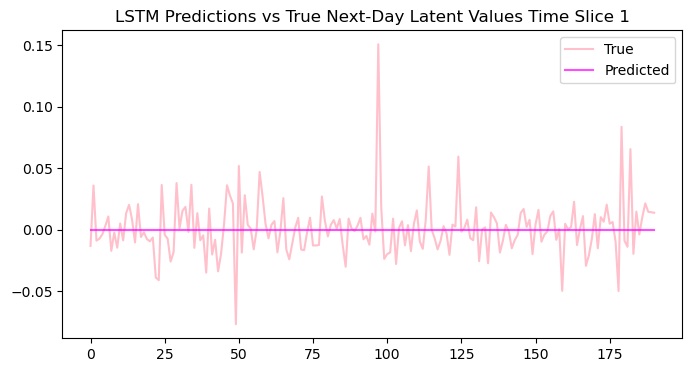

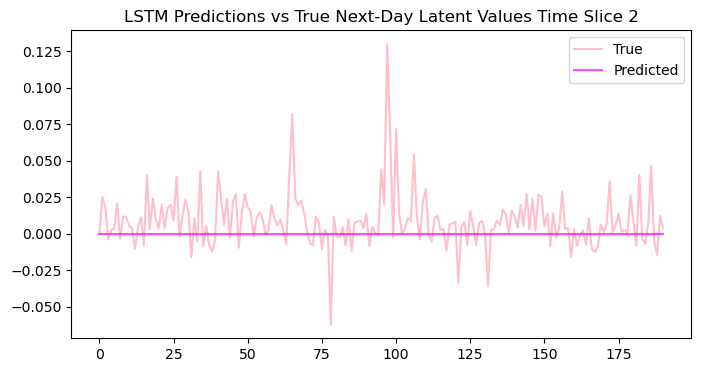

In [84]:
# test loop + graph of it 
model.eval()
criterion = nn.MSELoss()
test_loss = 0

with torch.no_grad():  # no gradients needed
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item() * X_batch.size(0)

avg_test_loss = test_loss / len(test_dataset)
print(f"Test Loss = {avg_test_loss:.6f}")


# Take first 50 sequences from test set for visualization
X_sample, y_sample = X_lstm[n_train:n_train+1], targets_tensor[n_train:n_train+1]
X2,Y2 = X_lstm[n_train+1:n_train+2], targets_tensor[n_train+1:n_train+2]    

model.eval()
with torch.no_grad():
    y_pred_sample = model(X_sample)
    y2pred = model(X2)

# y_sample and y_pred_sample are 1D or (batch, 1), so just flatten if needed
y_true = y_sample.numpy() if y_sample.dim() == 1 else y_sample.squeeze().numpy()
y_pred = y_pred_sample.numpy() if y_pred_sample.dim() == 1 else y_pred_sample.squeeze().numpy()
y2true = Y2.numpy() if Y2.dim() == 1 else Y2.squeeze().numpy()
y2pred = y2pred.numpy() if y2pred.dim() == 1 else y2pred.squeeze().numpy()

plt.figure(figsize=(8,4))
plt.plot(y_true, label='True',color='pink')
plt.plot(y_pred, label='Predicted', alpha=0.7,color='magenta')
plt.legend()
plt.title("LSTM Predictions vs True Next-Day Latent Values Time Slice 1")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(y2true, label='True',color='pink')
plt.plot(y2pred, label='Predicted', alpha=0.7,color='magenta')
plt.legend()
plt.title("LSTM Predictions vs True Next-Day Latent Values Time Slice 2")
plt.show()
